#	Some tries for PCA and dataset quality

In [2]:
import sys
import lalsimulation as lalsim
import lal
sys.path.insert(1, '/home/stefano/Desktop/Stefano/scuola/uni/tesi_magistrale/code/routines')
from GW_helper import *
import matplotlib.pyplot as plt
from ML_routines import *

In [4]:
    #loading dataset and splitting
theta_vector, amp_dataset, ph_dataset, frequencies = load_dataset("../datasets/GW_TD_dataset/GW_TD_dataset.dat", shuffle=False, N_grid = None) #loading dataset

train_frac = .8
train_theta, test_theta, train_amp, test_amp = make_set_split(theta_vector, amp_dataset, train_frac, 1e-21)
train_theta, test_theta, train_ph, test_ph   = make_set_split(theta_vector, ph_dataset, train_frac, 1.)

KeyboardInterrupt: 

s =  [ 0.28314365 -0.04705193]
3000
-0.12618809404702352 -0.0519009504752376


<IPython.core.display.Javascript object>


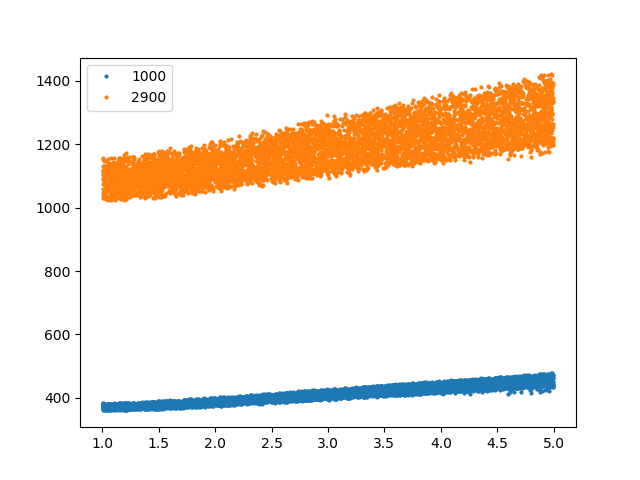

In [40]:
s = str(train_theta[0,1:])
print("s = ", s)
print(len(frequencies))
print(frequencies[1000], frequencies[1600])
%matplotlib notebook
for i in [1000,2900]:#,1000,1500,2000]:
    plt.plot(train_theta[:,0], train_ph[:,i], 'o', ms = 2, label = str(i))
plt.legend()
plt.show()

In [ ]:
plt.figure()
index_ = [1,7,24,51,32]
#%matplotlib notebook
for index in index_:
    plt.plot(frequencies, train_ph[index,:], label = str(train_theta[index,0]))
plt.legend()
plt.show()

In [30]:
K_ph = 11
ph_PCA = PCA_model()
E = ph_PCA.fit_model(train_ph, K_ph)
print("PCA eigenvalues: ", E)
PCA_train_ph = ph_PCA.reduce_data(train_ph)
PCA_test_ph = ph_PCA.reduce_data(test_ph)

PCA eigenvalues:  [5.44470998e+10 4.93018136e+08 2.95282442e+06 7.36267991e+05
 6.92313549e+04 4.47656488e+04 3.11561358e+04 6.18256426e+03
 4.34597200e+03 2.09301153e+03 1.12225331e+03]


<IPython.core.display.Javascript object>


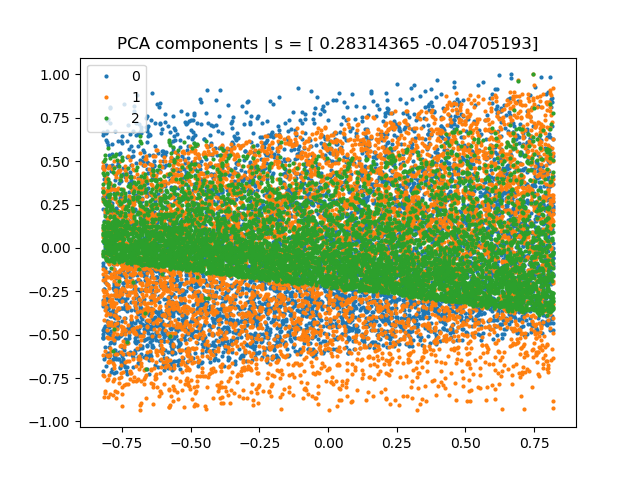

In [36]:
plt.figure()
plt.title("PCA components | s = "+str(s))
for i in range(3):#(K_ph):
    plt.plot(train_theta[:,2], PCA_train_ph[:,i], 'o', ms = 2, label = str(i))
plt.legend()
plt.show()

In [37]:
#computing mismatches
rec_test_ph = ph_PCA.reconstruct_data(np.multiply(PCA_test_ph,max_ph))
F = compute_mismatch(test_amp, test_ph, test_amp, rec_test_ph)
print("Avg mismatch: ", np.mean(F))

Avg mismatch:  6.124892650790345e-05


Checking if it's all right with the waves

In [8]:
#choosing wafeform to compare
indices = 9
print("Waveform chosen: ", train_theta[indices,:])

Waveform chosen:  [ 4.77381751 -0.63693828  0.39953208]


In [9]:
print("Generating wave with: ", train_theta[indices,:])
f_high = 1000; f_step = 5e-2; f_low = 20; d = 1.
m2 = 10.
m1 = train_theta[indices,0]*m2
spin1z = train_theta[indices,1]
spin2z = train_theta[indices,2]
LALpars = lal.CreateDict()
approx = lalsim.SimInspiralGetApproximantFromString("IMRPhenomPv2")

hptilde, hctilde = lalsim.SimInspiralChooseFDWaveform( #where is its definition and documentation????
    m1*lalsim.lal.MSUN_SI, #m1
    m2*lalsim.lal.MSUN_SI, #m2
    0, 0, spin1z, #spin vector 1
    0, 0, spin2z, #spin vector 2
    d*1e6*lalsim.lal.PC_SI, #distance to source
    0, #inclination
    0, #something I don't know
    0, #longAscNodes
    0, #eccentricity
    0, #meanPerAno
    f_step, # frequency incremental step
    f_low, # lowest value of frequency
    f_high, # highest value of frequency
    f_low, #some reference value of frequency (??)
    LALpars, #some lal dictionary
    approx #approx method for the model
    )
K = int((f_high-f_low)/f_step)
full_frequencies = np.arange(f_low, f_high, f_step)
h = np.array(hptilde.data.data)+1j*np.array(hctilde.data.data)
temp_amp = (np.abs(h)[int(f_low/f_step):int(f_high/f_step)].real)
temp_ph = (np.unwrap(np.angle(h))[int(f_low/f_step):int(f_high/f_step)].real)
temp_ph = temp_ph - temp_ph[0]
h = h[int(f_low/f_step):int(f_high/f_step)]
(index,) = np.where(temp_amp/temp_amp[0] < 5e-3)
if len(index) >0:
    temp_ph[index] = temp_ph[index[0]-1]

Generating wave with:  [ 4.77381751 -0.63693828  0.39953208]


33600.0 (19600,)
(19600,)


<IPython.core.display.Javascript object>


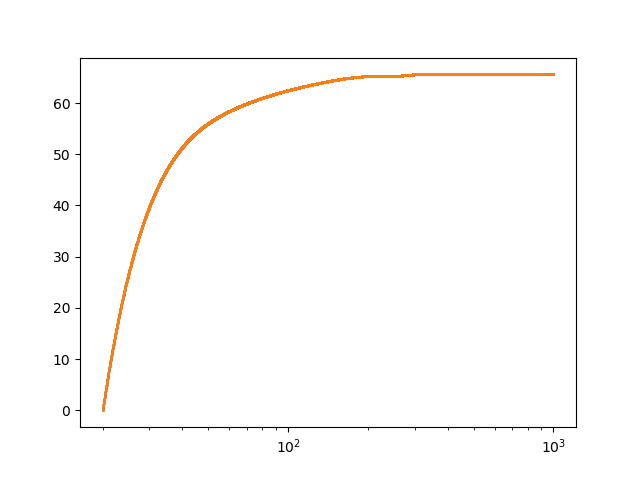

In [10]:
print((1700-f_low)/f_step, h.shape)
print(temp_amp.shape)
plt.figure()
#plt.plot(full_frequencies, h.real, 'o', ms = 1)
plt.plot(full_frequencies, temp_ph, 'o', ms = 1)
plt.plot(frequencies, train_ph[indices,:],'o',ms = 1)
plt.xscale("log")
plt.show()

<IPython.core.display.Javascript object>


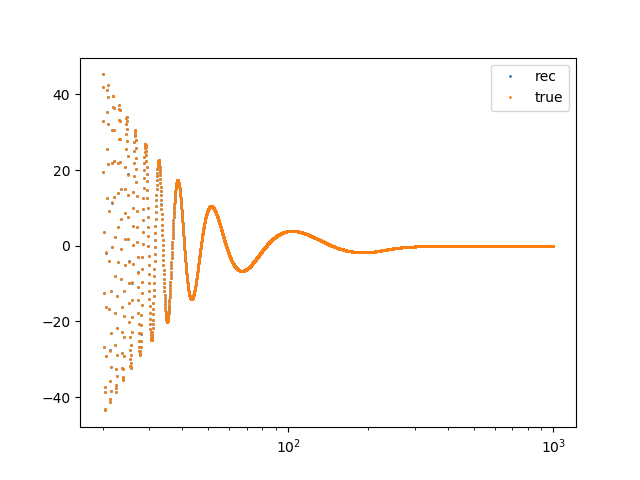

/home/stefano/anaconda3/envs/stefano_env/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [11]:
plt.figure()

new_ph = np.interp(full_frequencies, frequencies, train_ph[indices,:])
new_amp = np.interp(full_frequencies, frequencies, train_amp[indices,:])

#plt.plot(frequencies, train_amp[indices,:]*np.exp(1j*train_ph[indices,:]), 'o', ms = 2)
plt.plot(full_frequencies, new_amp*np.exp(1j*new_ph), 'o', ms = 1,label = "rec" )
plt.plot(full_frequencies, 1e21*temp_amp*np.exp(1j*temp_ph), 'o', ms = 1, label = "true")
plt.legend()
plt.xscale("log")
plt.show()

In [12]:
#computing mismatch
print("Mismatch: ", compute_mismatch(new_amp,new_ph, temp_amp, temp_ph)[0])

Mismatch:  2.166009616111353e-08
